## Gaze-based interaction

Andrew Howes

June 2022

Gaze-based interaction is the problem of selecting items presented on a computer with eye movements and fixations. The problem for the computer is to determine when a user's fixation represents the intention to select. The problem for the user is to make efficient eye movements towards an intended target and to hold fixation on the target.

Gaze-based interaction has been studied in human-computer interaction (HCI) since the 1990s and interest has been maintained throughout the intervening years. Recent technological advances, such as the addition of eye tracking capabilities to virtual reality and augmented reality (AR), have sparked another wave of interest.

One reason that gaze-based interaction is interesting is that eye-movements are highly strategic. For example, eye-movements tend to undershoot a target, presumably because, in the presence of uncertainty, undershooting costs less time than overshooting. Another interesting property of eye-movements to a target is that they obey Fitts's Law; that is the movement time of the eyes is proportional to the distance and inversely proportional to the size of the target.

The purpose of this notebook is to introduce a reinforcement learning model of how human's select a target by moving their eyes to it. The model is a version of that presented in Chen et al. (2021) that has been restructured for tutorial purposes.

Rather than strategies being programmed into the model, instead a policy for how to move the eyes is learned using reinforcement learning. The learned policy is the optimal solution to a problem that is defined by the constraints imposed by the oculomotor and perceptual systems. These constraints include the fact that eye-movements, fixations and visual perception are stochastic. Eye-movements for example, do not go exactly where cognition intends.

The constraints are defined in a cognitive architecture -- an information processing model of the mind.

### The cognitive architecture

<img src="image/architecture.png" alt="Box diagram of a cognitive model." width="700" height="400">

A cognitive architecture represents a commitment to a theory of how information is processed in the human mind. The cognitive architecture in the figure consists of five modules (inside the dashed box) that interact with an external world.

Below, the modules have the following properties:

* **World** On each trial, a circular target with a diameter "width" and a location (x,y) appears in the World. Target locations are randomly sampled from a bivariate Gaussian distribution centred at (0,0).
* **Perception** The location of target location stimuli are corrupted by Gaussian noise in human vision. The standard deviation of noise increases linearly with eccentricity from the fovea. 
* **Memory** Sequences of stimuli are optimally integrated.
* **Utility** Rewards are received for getting closer to the target.
* **Motor** Intended eye movements (oculomotor actions) are corrupted by signal dependent Gaussian noise to generate responses.
* **Control**  The Control module observes the memory and receives a reward. It learns a policy for making eye movements to the target that maximises the reward.

A python implementation of each module is described below.



## Configuration and imports

In [1]:
# This cell only for users of Google Colab.
# No need to run this if you are using Jupyter notebooks
# Mount Google drive and change directory into the project folder
# Only needs to be run once

#!pip install stable_baselines3

#from google.colab import drive
#drive.mount('/content/drive')

#%cd '/content/drive/MyDrive/CHI22CMT/CHI22_CogMod_Tutorial/03-Reinforcement-Learning/034_Gaze_based_Interaction'


In [2]:
# Load local modules
# gazetools is a module that contains functions for modeling gaze-based interaction.

from gazetools import *


## Modules

### World Module

The World module allows us to make predictions from the theory for a particular task. The theory makes predictions for many more tasks. For example, adaptation to mixed target widths and distances. The World generates a **stimulus** that includes the target location and width and the agent can **respond** with an eye-movement.


In [3]:
class GazeTask():
    
    def __init__(self, theta):
        self.theta=theta

    def reset(self):
        ''' The external_state includes the fixation and target location.
        Choose a new target location and reset to the first fixation location.'''
        
        def _get_new_target():
            x_target = np.clip(np.random.normal(0, self.theta['target_loc_std']),-1,1)
            y_target = np.clip(np.random.normal(0, self.theta['target_loc_std']),-1,1)         
            return np.array( [x_target, y_target] )
    
        # the initial fixation
        self.fixation = np.array([-1,-1])
        # the target location for this episode
        self.target = _get_new_target()

    def step(self, response):
        self.fixation = response
        
        # determine when the goal has been achieved.
        distance = get_distance(self.fixation, self.target)
        if distance < self.theta['target_width']/2 :
            done = True
        else:
            done = False
        
        stimulus = {'fixation': self.fixation, 'target':self.target, 'width':self.theta['target_width']}
        return stimulus, done


class World(GazeTask):
    pass


### Perception Module

In [4]:

class Vision():

    def __init__(self, theta):
        self.theta = theta
    
    def reset(self):
        pass
    
    def step(self, stimulus):
        ''' define a psychologically plausible visual perception function in which acuity 
        falls off with eccentricity.''' 
        eccentricity = get_distance( stimulus['target'], stimulus['fixation'] )
        estimate_std = self.theta['perceptual_noise_weight'] * eccentricity
        noise = np.random.normal(0, estimate_std, stimulus['target'].shape)
        # stimulus is the external target location plus noise
        estimate = stimulus['target'] + noise
        percept = {'value': estimate, 'noise':estimate_std, 'distance':eccentricity, 'width':stimulus['width']}
        return percept

class Perception(Vision):
    pass


### Memory Module

In [5]:
class Memory():
    ''' Keep a memory of percepts. Compute an observation of memory. '''
    
    def __init__(self, theta):
        self.reset()
        
    def reset(self):
        self.belief = np.array([0,0])
        self.belief_std = 0.1
        observation = np.array([self.belief[0], self.belief[1], self.belief_std])
        return observation
    
    def step(self, percept):
        posterior, posterior_std = self.bayes_update(percept['value'], 
                                                     percept['noise'], 
                                                     self.belief,
                                                     self.belief_std)
        self.belief = posterior
        self.belief_std = posterior_std

        observation = np.array([self.belief[0], self.belief[1], self.belief_std])
        return observation

    def bayes_update(self, percept, percept_std, prior, prior_std):
        ''' A Bayes optimal function that integrates multiple stimuli.
        The belief is the prior.'''
        z1, sigma1 = percept, percept_std
        z2, sigma2 = prior, prior_std
        w1 = sigma2**2 / (sigma1**2 + sigma2**2)
        w2 = sigma1**2 / (sigma1**2 + sigma2**2)
        posterior = w1*z1 + w2*z2
        posterior_std = np.sqrt( (sigma1**2 * sigma2**2)/(sigma1**2 + sigma2**2) )
        return posterior, posterior_std
    

### Utility Module

In [6]:

class Utility():
    ''' Compute the reward given an observation '''
    
    def __init__(self, theta):
        pass
    
    def reset(self):
        pass
    
    def step(self, observation):
        
        if observation['distance'] < observation['width'] / 2:
            reward = 0
        else:
            reward = -observation['distance'] # a much better model of the psychological reward function is possible.
            
        return reward


### Motor Module

In [7]:

class Oculomotor():
    
    def __init__(self, theta):
        ''' The current fixation is part of the motor system state. '''
        self.theta = theta
        self.fixation = np.array([-1,-1])
    
    def reset(self):
        pass
    
    def step(self, action):
        '''  Add noise to the action and execute it in the world.'''
        distance = get_distance( self.fixation, action )
        
        oculomotor_noise = np.random.normal(0, self.theta['oculomotor_noise_weight'] * distance, action.shape)
        
        # response is action plus noise
        response = action + oculomotor_noise
        
        # update the oculomotor state
        self.fixation = response
        
        # make an adjustment if response is out of range. 
        response = np.clip(response,-1,1)
        
        return response

class Motor(Oculomotor):
    pass


### Control Module

The control module uses RL to find an optimal policy.


In [8]:
class Control():
    
    def __init__(self, theta, env):
        self.env = env
    
    def train(self, timesteps):
        ''' Train the control module to find the optimal policy for the Gym environment.
            Monitor() and PPO() are part of the stable_baselines3 package.
            PPO (Proximal Policy Optimisation) is a class of RL algorithm https://openai.com/blog/openai-baselines-ppo/
            '''
        self.env = Monitor(self.env, output_dir)
        self.policy = PPO('MlpPolicy', self.env, verbose=0, clip_range=0.15)
        self.policy.learn(total_timesteps=int(timesteps))
        self.policy.save(f'{output_dir}{policy_file}')
        print('Done training.')

    def run(self, n_episodes, filename):
        '''
        run the model for n_episodes and save its behaviour in a csv file.
        Note that 'env' is a term used by Gym to describe everything but the controller.
        '''
        max_episodes = 900000
        if n_episodes > max_episodes:
            print(f'We ask that you limit training to a max of {max_episodes} on the School of Computer Science AWS account.')
            print(f'If you want to run more training episodes then please do so on a local computer.')
            return

        result = []
        # repeat for n episodes
        eps = 0
        while eps < n_episodes:                
            done = False
            step = 0
            obs = self.env.reset()
            # record the initial state
            info = self.env.get_info(obs, 0, False)
            info['episode'] = eps
            result.append(info)
            # repeat until the gaze is on the target.
            while not done:
                step+=1
                # get the next prediction action from the policy
                action, _ = self.policy.predict(obs,deterministic = True)
                obs, reward, done, info = self.env.step(action)
                info['episode'] = eps
                result.append( info )
                if done:
                    eps+=1
        path = f'{output_dir}{filename}'
        df = pd.DataFrame(result)
        df.to_csv(path,index=False)
        return df


## The Model

The model is our model of cognition and the world. It is the environment for the control module. It defines the information flow between the modules defined above. 

It is defined as a Gym environment. For further information see: https://gym.openai.com/. gym.Env is a class provided by this library. The environments step function receives the action the controller and returns an observation.


In [9]:
class CogEnv(gym.Env):
    ''' The CogEnv defines the environment for the controller.
    '''
    
    def __init__(self, theta={}, max_steps=10):

        self.theta = theta
        
        self.motor = Motor(theta)
        self.world = World(theta)
        self.perception = Perception(theta)
        self.utility = Utility(theta)
        self.memory = Memory(theta)
        # The CogEnv defines the environment for the controller and therefore a Control object is not defined here.
        
        # The action_space and observation_space are required by gym. These define the range of each variable.
        # Each action has an x,y coordinate therefore the box size is 2.
        # Each obs has a an x,y and an uncertainty therefore the box size is 3.
        
        self.action_space = default_box(2)
        self.observation_space = default_box(3)
        
        # max_fixations per episode. Used to curtail exploration early in training.
        self.max_steps = max_steps
        
    def reset(self):
        
        self.motor.reset()
        self.world.reset()
        self.perception.reset()
        self.utility.reset()
        observation = self.memory.reset()

        self.n_step = 0

        return observation

    def step(self, action):
        ''' Define the information flow between the modules. '''
        response = self.motor.step(action)
        stimulus, done = self.world.step(response)
        percept = self.perception.step(stimulus)
        observation = self.memory.step(percept)
        reward = self.utility.step(percept)
        
        self.n_step+=1
        # give up if been looking for too long
        if self.n_step > self.max_steps:
            done = True
            reward = -2
            
        info = self.get_info( observation, reward, done )
        
        return observation, reward, done, info

    def get_info(self, observation, reward, done ):
        return {'step': self.n_step,
                #'observation': observation,
                'reward': reward,
                'done': done,
                'target_width': self.theta['target_width'],
                'target_x': self.world.target[0],
                'target_y': self.world.target[1],
                'fixation_x': self.world.fixation[0],
                'fixation_y': self.world.fixation[1]}


## Parameters

Define the model parameters

In [10]:
theta = {'perceptual_noise_weight': 0.09,
         'target_width': 0.15,
         'target_loc_std': 0.3,
         'oculomotor_noise_weight': 0.01
        }

## Test the model

Step through the untrained model to check for simple bugs. Output a DataFrame with a row for each step.
More comprehensive tests needed.

In [11]:
model = CogEnv( theta=theta, max_steps=10 )

model.reset()

def step_test():
    j=0
    result = []
    done = False
    model.reset()
    while not done:
        # make a step with a randomly sampled action
        obs, reward, done, info = model.step(model.action_space.sample())
        result.append(info)
        j+=1
    df = pd.DataFrame(result)
    return df, j

info, i = step_test()

info

,step,reward,done,target_width,target_x,target_y,fixation_x,fixation_y
0,1,-0.866303,False,0.15,-0.262329,-0.15748,0.345225,0.460063
1,2,-0.767400,False,0.15,-0.262329,-0.15748,-0.067748,0.584841
2,3,-1.047992,False,0.15,-0.262329,-0.15748,0.780278,-0.051375
3,4,-0.395106,False,0.15,-0.262329,-0.15748,-0.392773,0.215472
4,5,-0.727718,False,0.15,-0.262329,-0.15748,0.465320,-0.147364
5,6,-0.359554,False,0.15,-0.262329,-0.15748,-0.542968,-0.382248
6,7,-0.950125,False,0.15,-0.262329,-0.15748,-0.071345,0.773252
7,8,-0.455036,False,0.15,-0.262329,-0.15748,-0.520690,-0.532057
8,9,-0.443442,False,0.15,-0.262329,-0.15748,-0.341437,0.278848
9,10,-1.145786,False,0.15,-0.262329,-0.15748,-0.745485,0.881454


Calculate the average number of steps taken by the untrained model.

In [12]:
def mean_steps_taken():
    rs = []
    for k in range(0,10):
        info, i = step_test()
        rs.append(i)
    return sum(rs) / len(rs)

model.max_steps = 1000

r = mean_steps_taken()
        
print(r)

202.0


## Train the control module

We can train the control module to generate a policy.

By plotting the learning curve we can see whether the performance improves with training and whether the model approaches an optimum performance. We are interested in approximately optimal performance, so if the training curve is not approaching asymptote then we need to train with more timesteps or revise the model.

We can see that at first the model uses hundreds of fixations to find the target, this is because it has not yet learned to move the gaze in a way that is informed by the observation. As it learns to do this, it takes fewer steps to gaze at the target and its performance improves.

If our problem definition is correct then the model will get more 'human-like' the more that it is trained. In other words, training makes it a better model of interaction.

If we assume that people are computationally rational then the optimal solution to the gaze problem (as defined above) predicts human behavior.

Done training.


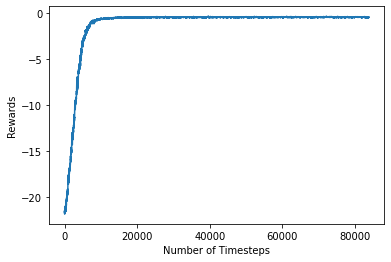

In [13]:
model.max_steps = 20
control = Control(theta, model)

timesteps = 300000

control.train(timesteps)
plot_learning_curve()

You should see a 'learning curve' in which as the model is trained with more 'timesteps' its performance improves. With more timesteps the rewards of each episode increase.

### Run the model
Run the trained model and save a trace of each episode to csv file.

In [14]:
control.run( 1000, 'behaviour_trace.csv' )

,step,reward,done,target_width,target_x,target_y,fixation_x,fixation_y,episode
0,0,0.000000,False,0.15,0.154578,0.036043,-1.000000,-1.000000,0
1,1,-0.204402,False,0.15,0.154578,0.036043,-0.041435,-0.021915,0
2,2,0.000000,True,0.15,0.154578,0.036043,0.165105,0.031278,0
3,0,0.000000,False,0.15,0.408209,-0.529194,-1.000000,-1.000000,1
4,1,-0.679247,False,0.15,0.408209,-0.529194,-0.042591,-0.021103,1
...,...,...,...,...,...,...,...,...,...
3250,1,-0.215824,False,0.15,0.169641,-0.073572,-0.038866,-0.017851,998
3251,2,0.000000,True,0.15,0.169641,-0.073572,0.180348,-0.095328,998
3252,0,0.000000,False,0.15,0.071729,-0.289172,-1.000000,-1.000000,999
3253,1,-0.287737,False,0.15,0.071729,-0.289172,-0.042456,-0.025061,999


### Excercise

Retrain the control module but with timesteps=300000. Inspect the learning curve and note that there is now a clear asymptote in performance which approaches 0 loss.

Rerun the model to generate a new behaviour_trace.csv

## Next

Congratulations, you have now completed a Python notebook that introduces you to how to model cognition with RL. 

Now go to notebook 'visualise' to see an animation of the results in behaviour_trace.csv.

## References
Chen, X., Acharya, A., Oulasvirta, A., & Howes, A. (2021, May). An adaptive model of gaze-based selection. In Proceedings of the 2021 CHI Conference on Human Factors in Computing Systems (pp. 1-11).